In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.metrics import *

In [2]:
#import data
bnp_data = pd.read_csv("../cleaned_data.csv")
bnp_data = add_features(bnp_data, window_sizes=[5, 10])

In [3]:
features=['Adj Close', 'Close', 'Volume','Log Return','ma_close_10','ma_volume_5']

In [4]:
gap = 100  # Gap between each subset

total_samples = len(bnp_data)
train_size = int(0.58 * total_samples)
test_size = int(0.17 * total_samples)
validation_size = int(0.17 * total_samples)

train,test,validation=data_splitting(bnp_data,train_size,test_size,validation_size,gap)

In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scaler for the target to inverse transform y_pred 
target = train[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scaler for the training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[features])
scaled_train = pd.DataFrame(scaled_train, columns=features)

# Applying the scaler of the training set onto test and validation set
scaled_test = scaler.transform(test[features])
scaled_test = pd.DataFrame(scaled_test, columns=features)

scaled_validation = scaler.transform(validation[features])
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

In [6]:
timesteps = 10
X_train, y_train = create_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps)

<h2>Forecast Horizons</h2>

In [7]:
horizon=50
timesteps=10

In [8]:
def create_multistep_sequences(data, target_column, timesteps, forecast_horizon):
    """
    Creates sequences for forecasting multiple steps into the future.
    :param data: Input DataFrame
    :param target_column: Column to forecast
    :param timesteps: Number of timesteps in each sequence
    :param forecast_horizon: How far into the future to predict
    :return: Tuple of (X, y)
    """
    X, y = [], []
    for i in range(len(data) - timesteps - forecast_horizon + 1):
        X.append(data.iloc[i:i + timesteps].values)
        y.append(data.iloc[i + timesteps + forecast_horizon - 1][target_column])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)
X_test, y_test = create_multistep_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)
X_validation, y_validation = create_multistep_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)

In [9]:
# Build and train the LSTM model
model = build_lstm_cnn((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 128)         │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,569 (428.00 KB)

 Trainable params: 109,569 (428.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0698 - val_loss: 0.1206
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.0876
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0857
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0900
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.1020
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0999
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.1351
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.1034
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0865
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.1301
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.1146
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [10]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 6.5965
NSE: 0.3099


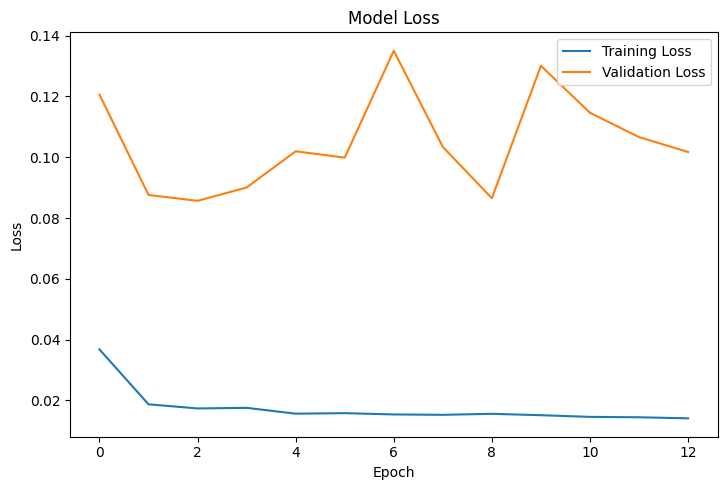

In [11]:
plot_learning_curves(history)

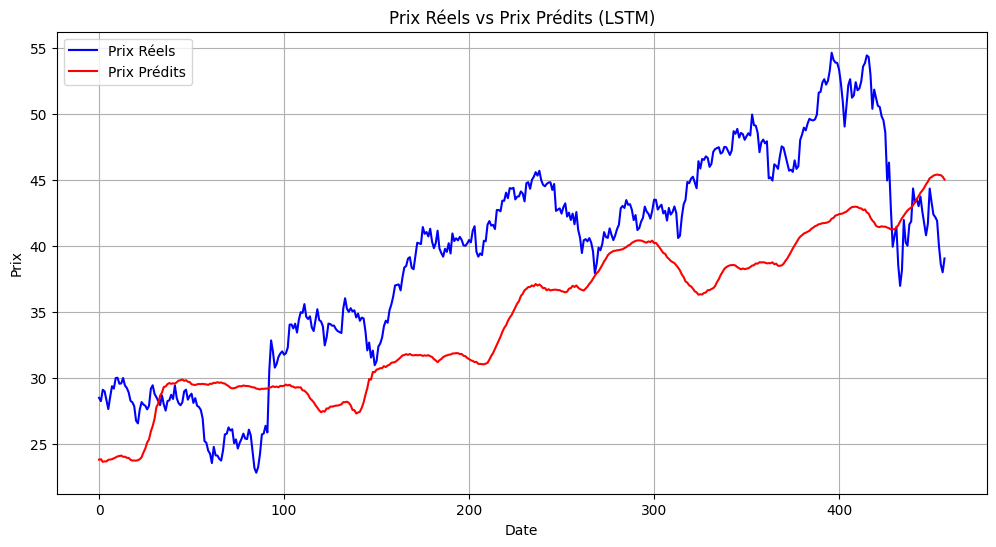

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()


In [13]:
def persistence_model(y_actual, horizon):
    """
    Implements a persistence model.
    :param y_actual: Array of true values
    :param horizon: Forecast horizon
    :return: Array of predictions
    """
    y_pred = y_actual[:-horizon]
    return y_pred

# Example usage:
# True values for comparison
true_values = y_test[horizon:]  # Exclude first 'horizon' values
y_pred = persistence_model(y_test, horizon)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(true_values.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

RMSE: 5.5308
NSE: 0.4426


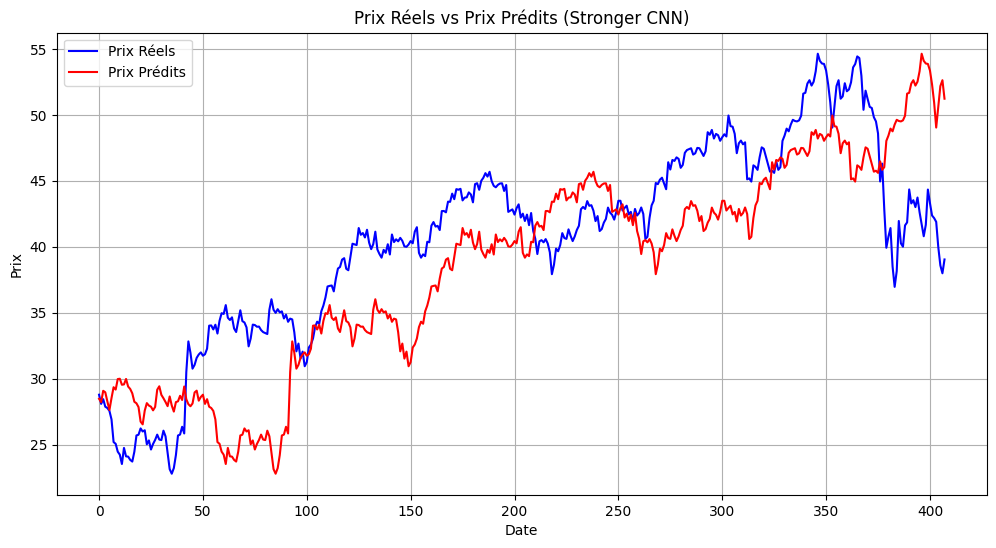

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()